## Benchmark: Sentimental Analysis

In [1]:
from sentimental_hwglu.naive_sa import NaiveSA
from sentimental_hwglu.utils import loadIMDBdataset, tokenizer_porter, Project
from sentimental_hwglu.words_statistics import WordStatistics
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time
import re


In [3]:
project = Project('/data/')
df = loadIMDBdataset(filename=project.csv_filename_clean)

In [4]:
df.head

<bound method NDFrame.head of                                                  reviews  sentiment
0      this 1931 comedy gets better with every viewin...          1
1      maybe it s because i m no fan of the comics bu...          0
2      this service comedy for which peter marshall j...          0
3      9 10 30 minutes of pure holiday terror okay so...          1
4      this drummond entry is lacking in continuity m...          0
...                                                  ...        ...
49995  it s painfully clear that all effort in this f...          0
49996   little man now on dvd is a wayans brothers fl...          0
49997  this one of the best celebrity s reality shows...          0
49998  someone must have been seriously joking when t...          0
49999  does anyone know where i could get my hands on...          1

[50000 rows x 2 columns]>

In [4]:
splitter_tokenizer = lambda x : x.split()


def timer_func(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time.time()
        result = func(*args, **kwargs)
        t2 = time.time()
        print(f' function executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

class LengthSentiencesHistograms:
    def __init__(self) -> None:
        self._lengths = []
        self._freq = []
    
    def _reset(self):
        self._lengths = []
        self._freq = []
    
    def create(self, map_data: map):
        for l in sorted(list(map_data.keys())):
            self._lengths.append(l)
            self._freq.append(map_data[l])
        self._lengths = np.array(self._lengths)
        self._freq = np.array(self._freq)
    
    def getHist(self):
        x, y = self._lengths, self._freq
        return x, y

class LengthWordsHistograms:
    def __init__(self) -> None:
        self._lengths = []
        self._freq = []
    
    def _reset(self):
        self._lengths = []
        self._freq = []
    
    def create(self, set_words):
        map_length_freq = {}
        if type(set_words) == map:
            set_words = set_words.keys()
        for w in set_words:
            try: map_length_freq[len(w)] += 1
            except KeyError: map_length_freq[len(w)] = 1
        for l in sorted(list(map_length_freq.keys())):
            self._lengths.append(l)
            self._freq.append(map_length_freq[l])
        self._lengths = np.array(self._lengths)
        self._freq = np.array(self._freq)
    
    def getHist(self):
        x, y = self._lengths, self._freq
        return x, y

class SentienceStatistics:
    def __init__(self, df) -> None:
        self._tag_review = "reviews"
        self._tag_sentitment = "sentiment"
        self._X = df[self._tag_review]
        self._y = df[self._tag_sentitment]
        self._positive_revies_number_sentences = {}
        self._negative_reviews_number_sentences = {}
        self._positive_revies_wrods_in_sentences = {}
        self._negative_reviews_wrods_in_sentences = {}
        self._positive_length_review = {}
        self._negative_length_review = {}
        self._positive_words_in_review = {}
        self._negative_words_in_review = {}
        
    @timer_func
    def analyseDataset(self):
        X_pos = self._X.loc[self._y.apply(WordStatistics.filter_pos)]
        X_neg = self._X.loc[self._y.apply(WordStatistics.filter_neg)]
        # ====================================================== #
        for k, reviews in enumerate([X_pos, X_neg]):
        # ====================================================== #
            tot = len(reviews)
            # ------------------------------------- #
            for n, review in enumerate(reviews):
            # ------------------------------------- #
                if (n%1000) == 0: print(" tokenization for review ", n, "/", tot, '         ', end='\r')
                len_review = len(review)
                sentences = re.split('\.|!|\?|:', review)
                n_sentences = len(sentences)
                # ======================================== #
                if k == 0:
                    try: self._positive_length_review[len_review] += 1
                    except KeyError: self._positive_length_review[len_review] = 1
                else:
                    try: self._negative_length_review[len_review] += 1
                    except KeyError: self._negative_length_review[len_review] = 1
                # ======================================== #
                if k == 0:
                    try: self._positive_revies_number_sentences[n_sentences] += 1
                    except KeyError: self._positive_revies_number_sentences[n_sentences] = 1
                else:
                    try: self._negative_reviews_number_sentences[n_sentences] += 1
                    except KeyError: self._negative_reviews_number_sentences[n_sentences] = 1
                # ======================================== #
                n_words = 0
                for s in sentences:
                    n_words += len(s.split())
                n_words = n_words / n_sentences
                if k == 0:
                    try: self._positive_revies_wrods_in_sentences[n_words] += 1
                    except KeyError: self._positive_revies_wrods_in_sentences[n_words] = 1
                else:
                    try: self._negative_reviews_wrods_in_sentences[n_words] += 1
                    except KeyError: self._negative_reviews_wrods_in_sentences[n_words] = 1
                # ======================================== #
                n_words = len(review.split())
                if k == 0:
                    try: self._positive_words_in_review[n_words] += 1
                    except KeyError: self._positive_words_in_review[n_words] = 1
                else:
                    try: self._negative_words_in_review[n_words] += 1
                    except KeyError: self._negative_words_in_review[n_words] = 1
                # ======================================== #
            # ======================================== #
    @property
    def NumberWordsPos(self): return self._positive_revies_wrods_in_sentences
    @property
    def NumberWordsNeg(self): return self._negative_reviews_wrods_in_sentences
    @property
    def NumberSentPos(self): return self._positive_revies_number_sentences
    @property
    def NumberSentNeg(self): return self._negative_reviews_number_sentences
    @property
    def ReviewLengthPos(self): return self._positive_length_review
    @property
    def ReviewLengthNeg(self): return self._negative_length_review
    @property
    def WordsPos(self): return self._positive_words_in_review
    @property
    def WordsNeg(self): return self._negative_words_in_review

class WordStatistics:

    index_neg = 0
    index_pos = 1
    filter_pos = lambda x : x == WordStatistics.index_pos
    filter_neg = lambda x : x == WordStatistics.index_neg

    def __init__(self, df) -> None:
        self._tag_review = "reviews"
        self._tag_sentitment = "sentiment"
        self._X = df[self._tag_review]
        self._y = df[self._tag_sentitment]
        self._positive_words = {}
        self._negative_words = {}
        self._common_words = {}
        self._only_positive_words = set()
        self._only_negative_words = set()
    
    def _reset_words_sets(self):
        self._positive_words = {}
        self._negative_words = {}
        self._common_words = {}
        self._only_positive_words = set()
        self._only_negative_words = set()

    @timer_func
    def _create_common_words(self):
        print(" create common words")
        words_pos = set(self._positive_words.keys())
        words_neg = set(self._negative_words.keys())
        words_common = words_pos.intersection(words_neg)
        for w in words_common:
            tmp = [0] * 2
            tmp[WordStatistics.index_neg] = self._negative_words[w]
            tmp[WordStatistics.index_pos] = self._positive_words[w]
            self._common_words[w] = tmp

    @timer_func
    def _create_only_positive_words(self):
        print(" create only positive words")
        words_pos = set(self._positive_words.keys())
        words_neg = set(self._negative_words.keys())
        self._only_positive_words = words_pos.difference(words_neg)

    @timer_func
    def _create_only_negative_words(self):
        print(" create only negative words")
        words_pos = set(self._positive_words.keys())
        words_neg = set(self._negative_words.keys())
        self._only_negative_words = words_neg.difference(words_pos)
    
    @timer_func
    def createWordsSets(self, tokenizer=splitter_tokenizer):
        """This function will create a map {word->freuquency}
        for positive and negative reviews.  """
        X_pos = self._X.loc[self._y.apply(WordStatistics.filter_pos)]
        X_neg = self._X.loc[self._y.apply(WordStatistics.filter_neg)]
        self._reset_words_sets()
        k = 0
        for set_words, reviews in [(self.positiveWords, X_pos), (self.negativeWords, X_neg)]:
            k += 1
            print(" running set_words ", k, "/ 2")
            # reset values
            # --------------------- #
            t0 = time.time()    
            tot = len(reviews)
            for n, review in enumerate(reviews):
            # --------------------- #
                if (n%1000) == 0:
                    print(" tokenization for review ", n, "/", tot, '         ', end='\r')
                tokens = tokenizer(review)
                # --------------------- #
                for tk in tokens:
                # --------------------- #
                    try: set_words[tk] += 1
                    except KeyError: set_words[tk] = 1
            # ------------------------- #
            t1 = time.time()    
            print(" tokenization took ", t1 - t0, " sec.")
        self._create_common_words()
        self._create_only_negative_words()
        self._create_only_positive_words()
        
    @property
    def positiveWords(self): return self._positive_words
    @property
    def negativeWords(self): return self._negative_words
    @property
    def commonWords(self): return self._common_words
    @property
    def onlyPositive(self): return self._only_positive_words
    @property
    def onlyNegative(self): return self._only_negative_words



In [13]:
ws = WordStatistics(df)
ws.createWordsSets(tokenizer=tokenizer_porter)

 running set_words  1 / 2
 tokenization took  111.65013670921326  sec.     
 running set_words  2 / 2
 tokenization took  109.6569402217865  sec.      
 create common words
 function executed in 0.0504s
 create only negative words
 function executed in 0.0079s
 create only positive words
 function executed in 0.0083s
 function executed in 221.4072s


In [14]:
print("postitive: ", len(ws.positiveWords))
print("negative: ", len(ws.negativeWords))
print("only-postitive: ", len(ws.onlyPositive))
print("only-negative: ", len(ws.onlyNegative))
print("common: ", len(ws.commonWords))

postitive:  52238
negative:  50024
only-postitive:  21574
only-negative:  19360
common:  30664


In [15]:
posLengthStat = LengthWordsHistograms()
posLengthStat.create(ws.positiveWords)
x_p, y_p = posLengthStat.getHist()

negLengthStat = LengthWordsHistograms()
negLengthStat.create(ws.negativeWords)
x_n, y_n = negLengthStat.getHist()

commLengthStat = LengthWordsHistograms()
commLengthStat.create(ws.commonWords)
x_c, y_c = commLengthStat.getHist()

onlyPositiveLengthStat = LengthWordsHistograms()
onlyPositiveLengthStat.create(ws.onlyPositive)
x_pp, y_pp = onlyPositiveLengthStat.getHist()

onlyNegativeLengthStat = LengthWordsHistograms()
onlyNegativeLengthStat.create(ws.onlyNegative)
x_nn, y_nn = onlyNegativeLengthStat.getHist()


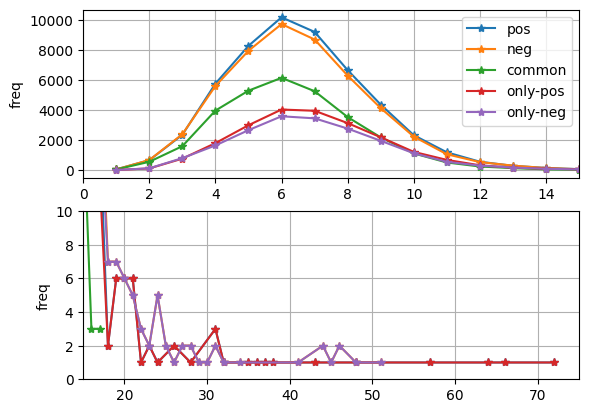

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)
for n, x_lim in enumerate(([0, 15], [15, 75])):
    line_style = '-*'
    ax[n].plot(
        x_p, y_p, line_style,
        x_n, y_n, line_style,
        x_c, y_c, line_style,
        x_pp, y_pp, line_style,
        x_nn, y_nn, line_style,
        )
    ax[n].set_ylabel('freq')
    if n == 0:
        ax[n].legend(['pos', 'neg', 'common', 'only-pos', 'only-neg'])
    ax[n].grid()
    if n == 0:
        ax[0].set_xlim(x_lim)
    else:
        ax[n].set_xlim(x_lim)
        ax[n].set_ylim([0, 10])
    fig.show()

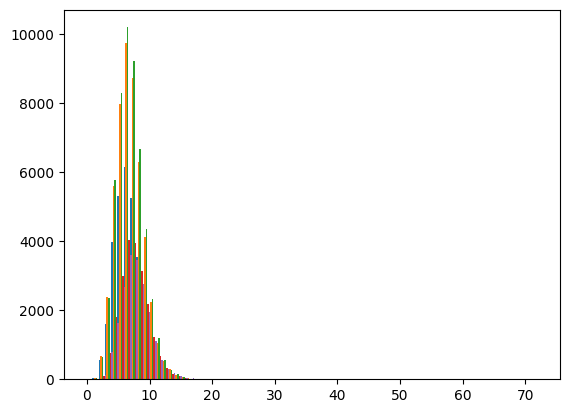

In [36]:
def create_bar_plot():
    for i, (x_bar, y_bar) in enumerate([
        (x_c, y_c), (x_n, y_n), (x_p, y_p), (x_pp, y_pp), (x_nn, y_nn)
    ]):
        xx = []
        yy = []
        for k in range(0, np.max(x_bar)):
            for n, p in enumerate(x_bar):
                if p == k:
                    xx.append(k)
                    yy.append(y_bar[n])
                else:
                    xx.append(k)
                    yy.append(0)
        plt.bar(0.25 * i + np.array(xx), yy, width=0.25)

In [124]:
print("""{""")
for type_data, suffix, xx, yy in [
    ("pos", "p", x_p, y_p),
    ("neg", "n", x_n, y_n),
    ("only_pos", "pp", x_pp, y_pp),
    ("only_neg", "nn", x_nn, y_nn),
    ("common", "c", x_c, y_c),
]:
# ========================================== #
    print("""   "%s": {""" % type_data)
    print("""        "x": np.array([""" + ','.join([str(x) for x in xx]) + "]),")
    print("""        "y": np.array([""" + ','.join([str(y) for y in yy]) + "]),")
    print("""   }, """)
# ========================================== #
print("""}""")
# x_n, y_n
# x_c, y_c
# x_pp, y_pp
# x_nn, y_nn

{
   "pos": {
        "x": np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,28,31,32,35,36,37,38,43,48,57,64,66,72]),
        "y": np.array([46,660,2358,5773,8301,10205,9228,6674,4369,2326,1183,555,283,141,61,19,15,2,6,6,6,1,2,1,2,1,3,1,1,1,1,1,1,1,1,1,1,1]),
   }, 
   "neg": {
        "x": np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,41,44,45,46,48,51]),
        "y": np.array([44,669,2392,5617,7972,9754,8722,6308,4135,2234,1054,532,295,133,55,33,19,7,7,6,5,3,2,5,2,1,2,2,1,1,2,1,1,1,2,1,2,1,1]),
   }, 
   "only_pos": {
        "x": np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,28,31,32,35,36,37,38,43,48,57,64,66,72]),
        "y": np.array([5,108,763,1800,2996,4044,3961,3136,2188,1214,678,318,156,93,45,16,12,2,6,6,6,1,2,1,2,1,3,1,1,1,1,1,1,1,1,1,1,1]),
   }, 
   "only_neg": {
        "x": np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,

In [113]:
def plot_words_frequencies(data_map):
    fig, ax = plt.subplots(2)
    data_keys = list(data_map.keys())
    for n, x_lim in enumerate(([0, 15], [15, 75])):
        line_style = '-*'
        for k in data_keys:
            ax[n].plot(
                np.array(data_map[k]["x"]),
                np.array(data_map[k]["y"]),
                style=line_style
            )
        ax[n].set_ylabel('freq')
        if n == 0:
            ax[n].legend(data_keys)
        ax[n].grid()
        if n == 0:
            ax[0].set_xlim(x_lim)
        else:
            ax[n].set_xlim(x_lim)
            ax[n].set_ylim([0, 10])
    fig.show()

In [121]:
data_freq = {
   "pos": {
        "x": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,28,31,32,35,36,37,38,43,48,57,64,66,72],
        "y": [46,660,2358,5773,8301,10205,9228,6674,4369,2326,1183,555,283,141,61,19,15,2,6,6,6,1,2,1,2,1,3,1,1,1,1,1,1,1,1,1,1,1],
   }, 
   "neg": {
        "x": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,41,44,45,46,48,51],
        "y": [44,669,2392,5617,7972,9754,8722,6308,4135,2234,1054,532,295,133,55,33,19,7,7,6,5,3,2,5,2,1,2,2,1,1,2,1,1,1,2,1,2,1,1],
   }, 
   "only_pos": {
        "x": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,28,31,32,35,36,37,38,43,48,57,64,66,72],
        "y": [5,108,763,1800,2996,4044,3961,3136,2188,1214,678,318,156,93,45,16,12,2,6,6,6,1,2,1,2,1,3,1,1,1,1,1,1,1,1,1,1,1],
   }, 
   "only_neg": {
        "x": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,41,44,45,46,48,51],
        "y": [3,117,797,1644,2667,3593,3455,2770,1954,1122,549,295,168,85,39,30,16,7,7,6,5,3,2,5,2,1,2,2,1,1,2,1,1,1,2,1,2,1,1],
   }, 
   "common": {
        "x": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
        "y": [41,552,1595,3973,5305,6161,5267,3538,2181,1112,505,237,127,48,16,3,3],
   }, 
}

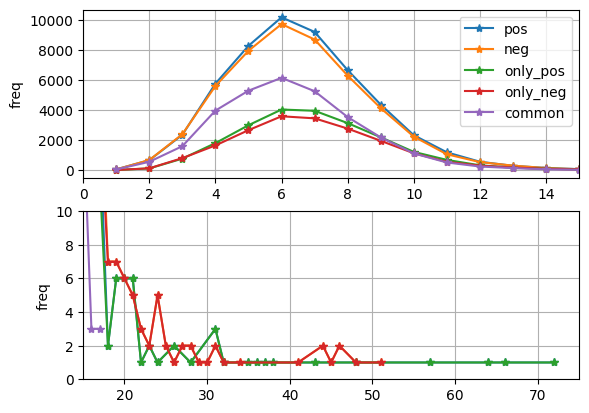

In [123]:
def plot_words_frequencies(data_map):
    fig, ax = plt.subplots(2)
    data_keys = list(data_map.keys())
    for n, x_lim in enumerate(([0, 15], [15, 75])):
        line_style = '-*'
        for k in data_keys:
            ax[n].plot(
                np.array(data_map[k]["x"]),
                np.array(data_map[k]["y"]),
                line_style
            )
        ax[n].set_ylabel('freq')
        if n == 0:
            ax[n].legend(data_keys)
        ax[n].grid()
        if n == 0:
            ax[n].set_xlim(x_lim)
        else:
            ax[n].set_xlim(x_lim)
            ax[n].set_ylim([0, 10])
    fig.show()

plot_words_frequencies(data_freq)

## Sentence Analysis

In [5]:
sen_stat = SentienceStatistics(df)
sen_stat.analyseDataset()

 function executed in 2.2608s00 / 25000          


In [54]:
print("S-neg: ", sen_stat.NumberSentNeg)
print("S-pos: ", sen_stat.NumberSentPos)
print("W-neg: ", sen_stat.NumberWordsNeg)
print("W-pos: ", sen_stat.NumberWordsPos)
print("Ws-neg: ", sen_stat.WordsNeg)
print("Ws-pos: ", sen_stat.WordsPos)
print("Len-neg: ", sen_stat.ReviewLengthNeg)
print("Len-pos: ", sen_stat.ReviewLengthPos)

S-neg:  {1: 24798, 2: 186, 4: 4, 3: 12}
S-pos:  {1: 24663, 2: 289, 6: 1, 3: 33, 4: 10, 5: 3, 7: 1}
W-neg:  {111.0: 93, 142.0: 153, 155.0: 125, 171.0: 109, 222.0: 55, 78.0: 49, 225.0: 65, 406.0: 21, 83.0: 49, 118.0: 121, 204.0: 77, 117.0: 119, 404.0: 16, 120.0: 127, 102.0: 55, 134.0: 163, 50.0: 60, 273.0: 39, 665.0: 8, 220.0: 64, 266.0: 41, 63.0: 49, 132.0: 195, 158.0: 134, 44.0: 35, 622.0: 7, 133.0: 183, 315.0: 26, 242.0: 55, 153.0: 143, 206.0: 65, 637.0: 1, 499.0: 12, 123.0: 149, 236.0: 44, 584.0: 5, 192.0: 88, 166.0: 88, 105.0: 57, 211.0: 75, 201.0: 70, 119.0: 135, 351.0: 25, 60.0: 44, 214.0: 71, 256.0: 52, 157.0: 118, 139.0: 161, 1005.0: 6, 1020.0: 3, 122.0: 156, 555.0: 10, 99.0: 52, 56.0: 57, 402.0: 28, 100.0: 66, 718.0: 6, 223.0: 51, 338.0: 28, 196.0: 76, 106.0: 79, 135.0: 171, 187.0: 95, 129.0: 179, 149.0: 143, 208.0: 60, 190.0: 84, 403.0: 16, 507.0: 14, 381.0: 14, 293.0: 39, 101.0: 60, 108.0: 77, 145.0: 142, 325.0: 18, 429.0: 12, 197.0: 89, 39.0: 20, 778.0: 4, 45.0: 36, 289.0: 3

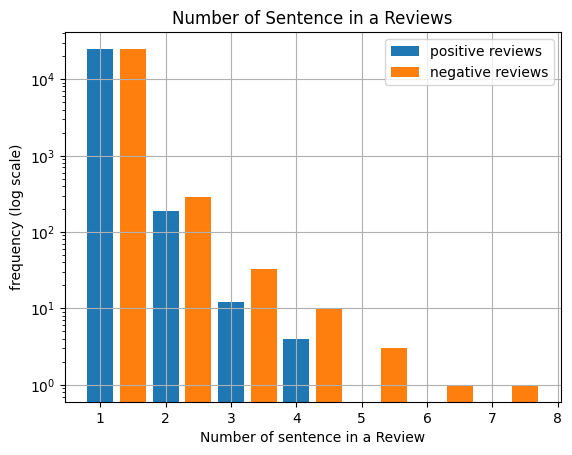

In [7]:
plt.grid()
plt.title("Number of Sentence in a Reviews")
plt.xlabel("Number of sentence in a Review")
plt.ylabel("frequency (log scale)")
for n, k in enumerate([sen_stat.NumberSentNeg, sen_stat.NumberSentPos]):
    h1 = LengthSentiencesHistograms()
    numSentNeg = h1.create(k)
    x1, y1 = h1.getHist()
    plt.bar(x1 + n * 0.5, y1, width=0.4)
plt.yscale('log')
plt.legend(['positive reviews', 'negative reviews'])

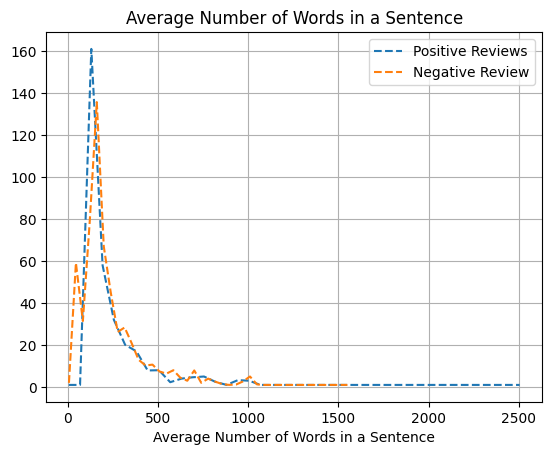

In [42]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import make_interp_spline, BSpline
# fig, ax = plt.subplots(2)
plt.grid()
plt.title("Average Number of Words in a Sentence")
plt.xlabel("Average Number of Words in a Sentence")
for n, k in enumerate([sen_stat.NumberWordsPos, sen_stat.NumberWordsNeg]):
    h1 = LengthSentiencesHistograms()
    numSentNeg = h1.create(k)
    x1, y1 = h1.getHist()
    xnew = np.linspace(x1.min(), x1.max(), num=41, endpoint=True)
    f = interp1d(x1, y1, kind='cubic')
    # f = make_interp_spline(x1, y1, k=3)
    plt.plot(xnew, f(xnew), '--')
    # plt.bar(x1 + n * 0.5, y1, width=0.4)
    # ax[n].plot(x1, y1)
    # plt.plot(x1, y1, '-.')
# plt.yscale('log')
plt.legend(['Positive Reviews', 'Negative Review'])
# plt.xlim([1, 500])

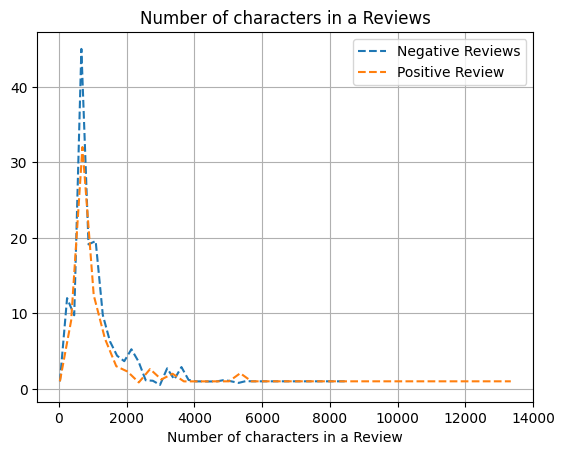

In [41]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import make_interp_spline, BSpline

plt.grid()
plt.title("Number of characters in a Reviews")
plt.xlabel("Number of characters in a Review")
for n, k in enumerate([sen_stat.ReviewLengthNeg, sen_stat.ReviewLengthPos]):
    h1 = LengthSentiencesHistograms()
    numSentNeg = h1.create(k)
    x1, y1 = h1.getHist()
    xnew = np.linspace(x1.min(), x1.max(), num=41, endpoint=True)
    f = interp1d(x1, y1, kind='cubic')
    # f = make_interp_spline(x1, y1, k=3)
    plt.plot(xnew, f(xnew), '--')
    # plt.bar(x1 + n * 0.5, y1, width=0.4)
    # plt.plot(x1, y1, '-*' if n == 0 else '-.')
plt.legend(['Negative Reviews', 'Positive Review'])

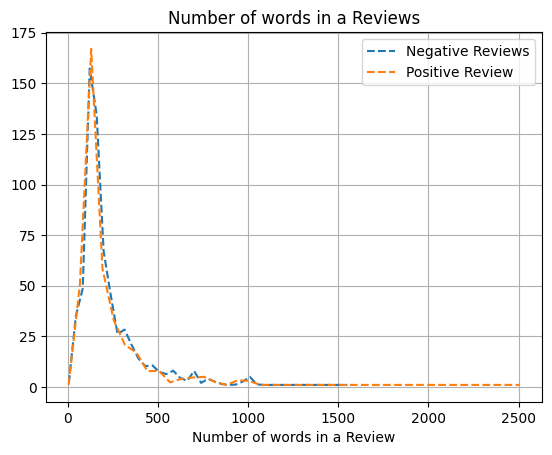

In [38]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import make_interp_spline, BSpline

plt.grid()
plt.title("Number of words in a Reviews")
plt.xlabel("Number of words in a Review")
for n, k in enumerate([sen_stat.WordsNeg, sen_stat.WordsPos]):
    h1 = LengthSentiencesHistograms()
    numSentNeg = h1.create(k)
    x1, y1 = h1.getHist()
    # plt.plot(x1, y1, '-*' if n == 0 else '-.')
    xnew = np.linspace(x1.min(), x1.max(), num=41, endpoint=True)
    f = interp1d(x1, y1, kind='cubic')
    # f = make_interp_spline(x1, y1, k=3)
    plt.plot(xnew, f(xnew), '--')
    # f = gaussian_filter1d(y1, sigma=2)
    # plt.bar(x1, f)
    # plt.bar(x1 + n * 0.5, y1, width=0.4)
# plt.yscale('log')
plt.legend(['Negative Reviews', 'Positive Review'])

In [52]:
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import make_interp_spline, BSpline

def plotSmoothSentenceStatistics(pos, neg, title):
    fig, axs = plt.subplots()
    axs.grid()
    axs.set_title(title)
    axs.set_xlabel(title)
    for n, k in enumerate([pos, neg]):
        h1 = LengthSentiencesHistograms()
        _ = h1.create(k)
        x1, y1 = h1.getHist()
        xnew = np.linspace(x1.min(), x1.max(), num=42, endpoint=True)
        f = interp1d(x1, y1, kind='cubic')
        axs.plot(xnew, f(xnew), '-.')
    axs.legend(['Positive Reviews', 'Negative Review'])

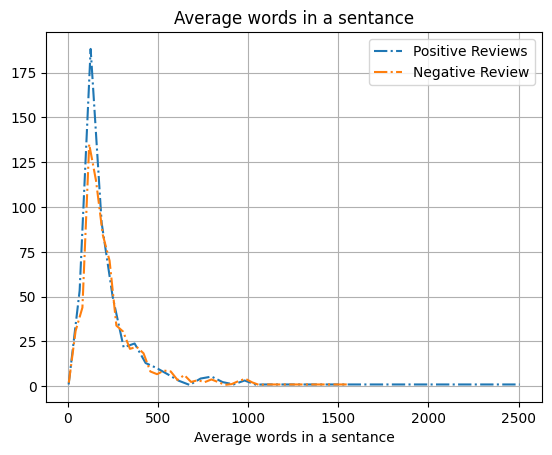

In [53]:
plotSmoothSentenceStatistics(sen_stat.WordsPos, sen_stat.WordsNeg, 'Average words in a sentance')